In [111]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [112]:
import pathlib
dataset_url = "https://drive.google.com/file/d/1-OX6wn5gA-bJpjPNfSyaYQLz-A-AB_uj/view?usp=sharing"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [113]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [114]:
# loading images using keras.preprocessing
# defining parameters for the loader
batch_size = 32
img_height = 240
img_width = 320

In [115]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [116]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/roses/7820626638_3e2d712303.jpg'
b'/root/.keras/datasets/flower_photos/tulips/113291410_1bdc718ed8_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/6146107825_45f708ecd7_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/15495579081_661cb260d1_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/26254755_1bfc494ef1_n.jpg'


In [117]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [118]:
val_size = int(image_count * 0.4)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [119]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2202
1468


In [120]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [121]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [122]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [123]:
AUTOTUNE = tf.data.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [124]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (240, 320, 3)
Label:  3


In [125]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

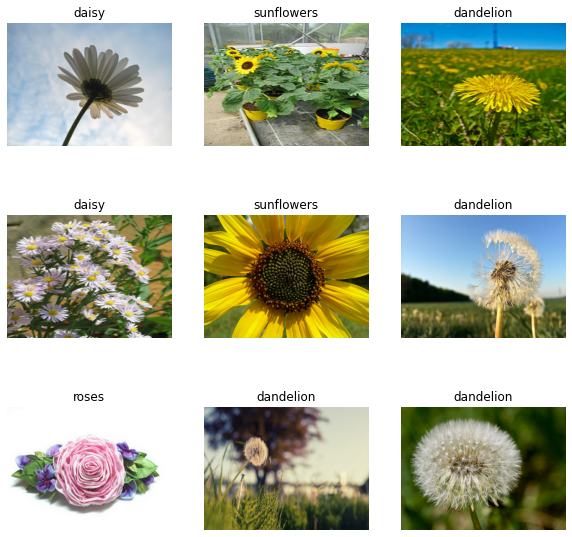

In [126]:
# visualize data
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [127]:
# Standardize the data
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [128]:
# build the model
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [129]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [130]:
model.fit(train_ds, epochs=5)

Epoch 1/5
69/69 [==============================] - 182s 3s/step - loss: 1.9728 - accuracy: 0.2888
Epoch 2/5
69/69 [==============================] - 175s 3s/step - loss: 1.1283 - accuracy: 0.5330
Epoch 3/5
69/69 [==============================] - 175s 3s/step - loss: 0.9091 - accuracy: 0.6611
Epoch 4/5
69/69 [==============================] - 181s 3s/step - loss: 0.6140 - accuracy: 0.7933
Epoch 5/5
69/69 [==============================] - 175s 3s/step - loss: 0.3727 - accuracy: 0.8744


In [131]:
model.evaluate(val_ds)

46/46 [==============================] - 37s 711ms/step - loss: 1.4354 - accuracy: 0.6090


[1.4353885650634766, 0.608991801738739]